### Creating a LSTM Model

In [65]:
from pymongo import MongoClient
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas()

In [26]:
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import LSTM , Dense , Flatten , Dropout , Input
from tensorflow.keras.callbacks import TensorBoard , EarlyStopping

In [67]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix , accuracy_score

In [28]:
actions = np.array(['hello' , 'thankyou' , 'iloveyou'])

# Creating Label Map 

label_map = {label:num for num , label in enumerate(actions)}

In [29]:
label_map

{'hello': 0, 'thankyou': 1, 'iloveyou': 2}

In [30]:
tf.random.set_seed(17)
np.random.seed(17)
random.seed(17)

#### 1. Extracting Data from MongoDB

In [31]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Preprocessed_Landmark_Data']

In [32]:
cursor = collection.find({})
df = pd.DataFrame(list(cursor))

In [33]:
df['Landmarks'] = df['Landmarks'].progress_apply(lambda landmarks : [np.array(x) if isinstance(x , list) else x for x in landmarks])

100%|██████████| 300/300 [00:00<00:00, 378.98it/s]


In [34]:
df['Landmarks'][0]

[array([ 0.5282082 ,  0.69970912, -0.78407443, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55254889,  0.63023722, -0.78952068, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55559933,  0.61130732, -0.7708981 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56082523,  0.60821176, -0.77176523, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56795919,  0.6058867 , -0.81826133, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56992733,  0.60519606, -0.77989995, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57354176,  0.60459828, -0.86566448, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57485545,  0.60356939, -0.90603018, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.5737077 ,  0.60355467, -0.84255922, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.57421315,  0.60291201, -1.03197324, ...,  0.        ,
         0.        ,  0.  

In [35]:
X = np.array(df['Landmarks'].tolist())
labels_list = (df['Labels'].tolist())
y = to_categorical(labels_list).astype(int)


In [36]:
X.shape

(300, 30, 1662)

In [37]:
y.shape

(300, 3)

In [38]:
X

array([[[ 0.5282082 ,  0.69970912, -0.78407443, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55254889,  0.63023722, -0.78952068, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55559933,  0.61130732, -0.7708981 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.62980717,  0.59732503, -1.28325009, ...,  0.47731709,
          0.40780509, -0.02713273],
        [ 0.63064581,  0.59841526, -1.25939536, ...,  0.48286542,
          0.40332043, -0.03363072],
        [ 0.62974828,  0.59842288, -1.20764422, ...,  0.44305485,
          0.3869282 , -0.03627616]],

       [[ 0.62721896,  0.59237534, -1.21063435, ...,  0.39933065,
          0.32641381, -0.06619024],
        [ 0.62298107,  0.5921942 , -1.05823302, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.62047112,  0.59255719, -1.09682631, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.53934711,  0.60268617, -0.99255943, ...,  

#### 2. Performing Train-test split
- using 95-5  percent train-test split

In [39]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.05)

In [40]:
print("X-train shape:" , X_train.shape)
print("X-test shape:" , X_test.shape)
print("y-train shape:" , y_train.shape)
print("y-test shape:" , X_test.shape)

X-train shape: (285, 30, 1662)
X-test shape: (15, 30, 1662)
y-train shape: (285, 3)
y-test shape: (15, 30, 1662)


Creating LSTM Model Architecture

In [41]:
# Creating a Instance of Early Stopping

early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 5,
 mode = 'min',
 restore_best_weights = True
)

In [42]:
X_train.shape

(285, 30, 1662)

In [43]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [44]:
# Constructing LSTM Model

LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences= True , activation = 'relu' , input_shape = (30 , 1662)))
LSTM_model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
# model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
LSTM_model.add(LSTM(64 , return_sequences= False , activation='relu'))
# model.add(Dense(128 , activation ='relu'))
# model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(64 , activation ='relu'))
LSTM_model.add(Dense(32 , activation = 'relu'))
LSTM_model.add(Dense(actions.shape[0] , activation='softmax'))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
LSTM_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,675 (2.28 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Compiling the Model 

LSTM_model.compile(optimizer='Adam' , loss = 'categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [47]:
LSTM_model_history = LSTM_model.fit(X_train , y_train , epochs = 500 , validation_split= 0.2)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - categorical_accuracy: 0.2158 - loss: 1.8102 - val_categorical_accuracy: 0.1228 - val_loss: 2.5829
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.2173 - loss: 1.9612 - val_categorical_accuracy: 0.4386 - val_loss: 1.0511
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4707 - loss: 1.0707 - val_categorical_accuracy: 0.4912 - val_loss: 1.0462
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.5535 - loss: 1.0319 - val_categorical_accuracy: 0.6667 - val_loss: 0.7830
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5968 - loss: 0.7875 - val_categorical_accuracy: 0.5965 - val_loss: 0.8499
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.5122 - loss: 0.7013 - val_categorical_accuracy: 0.7544 - val_loss: 0.5091
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.6444 - loss: 0.5510 - v

Visualizing the outcomes

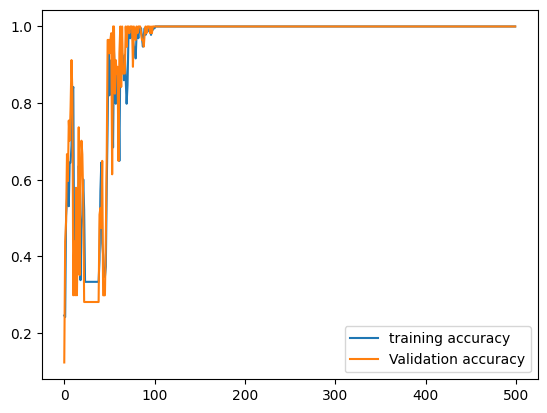

In [48]:
plt.plot(LSTM_model_history.history['categorical_accuracy'] , label = 'training accuracy')
plt.plot(LSTM_model_history.history['val_categorical_accuracy'] , label = 'Validation accuracy')
plt.legend(loc ='lower right')

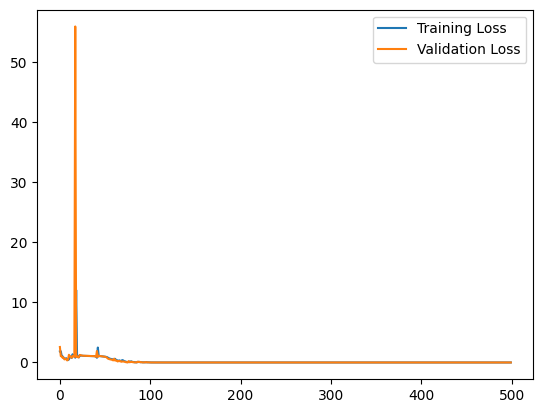

In [49]:
plt.plot(LSTM_model_history.history['loss'] , label = 'Training Loss')
plt.plot(LSTM_model_history.history['val_loss'] , label = 'Validation Loss')
plt.legend(loc = 'upper right')

In [50]:
LSTM_model.evaluate(X_test , y_test , verbose = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 1.0000 - loss: 3.8147e-07


[3.814694480297476e-07, 1.0]

#### 3. Predicting Results

In [51]:
predictions = LSTM_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


In [52]:
predictions[0]

array([4.053888e-17, 1.000000e+00, 4.534054e-10], dtype=float32)

In [53]:
actions[np.argmax(predictions[0])]

'thankyou'

In [54]:
actions[np.argmax(y_test[0])]

'thankyou'

In [55]:
results , actual = [] , []

for result in predictions:
  
  outcome = actions[np.argmax(result)]

  results.append(outcome)
  

for i in range(len(y_test)):

  act_out = actions[np.argmax(y_test[i])] 

  actual.append(act_out)


In [56]:
results

['thankyou',
 'hello',
 'thankyou',
 'thankyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'thankyou',
 'thankyou',
 'iloveyou',
 'hello',
 'thankyou',
 'thankyou',
 'thankyou',
 'hello']

In [57]:
actual

['thankyou',
 'hello',
 'thankyou',
 'thankyou',
 'iloveyou',
 'iloveyou',
 'iloveyou',
 'thankyou',
 'thankyou',
 'iloveyou',
 'hello',
 'thankyou',
 'thankyou',
 'thankyou',
 'hello']

In [58]:
type(results)

list

In [62]:
comparision_df = pd.DataFrame({'y_true' : actual , 'y_pred': results})

In [63]:
comparision_df

,y_true,y_pred
0,thankyou,thankyou
1,hello,hello
2,thankyou,thankyou
3,thankyou,thankyou
4,iloveyou,iloveyou
5,iloveyou,iloveyou
6,iloveyou,iloveyou
7,thankyou,thankyou
8,thankyou,thankyou
9,iloveyou,iloveyou


#### 4. Saving the model Weights

In [66]:
with open('LSTM_model' , 'wb') as file:
  pickle.dump(LSTM_model , file)

#### 5.Evaluation using Confusion Matrix and accuracy

In [86]:
y_hat = LSTM_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [87]:
y_hat

array([[4.0538881e-17, 1.0000000e+00, 4.5340540e-10],
       [1.0000000e+00, 3.7686180e-33, 2.2697011e-24],
       [4.4739082e-19, 1.0000000e+00, 1.1189851e-09],
       [3.7478406e-20, 1.0000000e+00, 1.1702784e-08],
       [2.4523897e-10, 6.9709847e-09, 1.0000000e+00],
       [9.1841085e-10, 3.3152316e-09, 1.0000000e+00],
       [1.4536185e-07, 1.5993656e-10, 9.9999988e-01],
       [5.4713717e-10, 9.9999905e-01, 9.5344512e-07],
       [1.8733500e-21, 1.0000000e+00, 5.1815267e-11],
       [1.3151116e-06, 2.2924501e-11, 9.9999869e-01],
       [1.0000000e+00, 1.8195046e-30, 8.7272831e-23],
       [1.4989818e-18, 9.9999857e-01, 1.3725794e-06],
       [5.2364304e-22, 1.0000000e+00, 2.0931878e-10],
       [2.1822948e-18, 9.9999809e-01, 1.8882230e-06],
       [1.0000000e+00, 3.9958764e-35, 8.2560395e-26]], dtype=float32)

In [88]:
y_hat =  np.argmax(y_hat , axis = 1).tolist()
y_true = np.argmax(y_test , axis = 1).tolist()

In [90]:
print(y_true)
print(y_hat)

[1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 1, 1, 0]
[1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1, 1, 1, 0]


In [92]:
multilabel_confusion_matrix(y_true , y_hat)

# This confusion matrix shows TP and TN for each and every class

array([[[12,  0],
        [ 0,  3]],

       [[ 7,  0],
        [ 0,  8]],

       [[11,  0],
        [ 0,  4]]], dtype=int64)

In [93]:
accuracy_score(y_true , y_hat)

1.0